In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import MINST data, split it into X ad Y, isolate X1, X2 and X3 from X <br>
where X1 = subdata of X containing 0, X2 = 6, X3 = 9

In [25]:
#function to randomly divide data into test and train sets
def trainTestSets(data):
    np.random.shuffle(data)
    #split data into X and Y
    X=data[:,1:].T 
    Y=data[:,0]
    d,N=X.shape
    #divide in Xtrain and Xtest
    trainSize=30000 
    Xtrain=X[:,:trainSize]
    Ytrain=Y[:trainSize]
    Xtest=X[:,trainSize:N]
    Ytest=Y[trainSize:N]
    return X, Y, Xtrain, Ytrain, Xtest, Ytest

#load data into memory
data=pd.read_csv("data.csv")
print(data.head())
#convert data into matrix
data=np.array(data)
#divide in train and test sets
X, Y, Xtrain, Ytrain, Xtest, Ytest = trainTestSets(data)
#isolate X1, X2, X3
i1= (Ytrain==0)
i2= (Ytrain==6)
i3= (Ytrain==9)

X1=Xtrain[:, i1]
X2=Xtrain[:, i2]
X3=Xtrain[:, i3]

Y1=Ytrain[i1]
Y2=Ytrain[i2]
Y3=Ytrain[i3]


   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [26]:
Xtrain=np.concatenate((X1,X2,X3), axis=1)
Ytrain=np.concatenate((Y1,Y2,Y3))

the difference between PCA and LDA is the <b>class centroid</b>
which is the centroid calculated considering just the class k

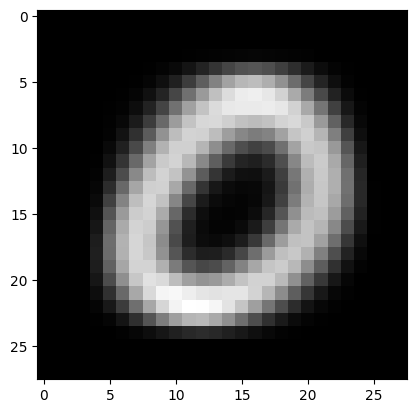

In [27]:
#calculate global and class centroids

#global centroid
C=np.mean(Xtrain, axis=1)

#class centroids
C1=np.mean(X1, axis=1)
C2=np.mean(X2, axis=1)
C3=np.mean(X3, axis=1)

plt.imshow(np.reshape(C1,(28,28)), cmap="gray") #C1 is the IMAGE (28*28), mean of all zeros

In [28]:
d=784
X1c=X1-C1.reshape((d,1))
X2c=X2-C2.reshape((d,1))
X3c=X3-C3.reshape((d,1))

Xw=np.concatenate((X1c, X2c, X3c), axis=1)
Sw= Xw@Xw.T #represents the spread of the data within each cluster
#it's SYMMETRICAL by construction
#it's not positive definite by contruction


Xbar1= np.repeat(C1.reshape(d,1), X1.shape[1], axis=1)
Xbar2= np.repeat(C2.reshape(d,1), X2.shape[1], axis=1)
Xbar3= np.repeat(C3.reshape(d,1), X3.shape[1], axis=1)

Xbar=np.concatenate((Xbar1, Xbar2, Xbar3), axis=1)
Xbarc=Xbar-C.reshape((d,1)) #we can't subtract matrix and vector, but we can subtract matrix and column vector (that's wy we reshape C)

Sb=Xbarc @ Xbarc.T #represent the spread between different clusters
print(Sb.shape)

(784, 784)


we need to <b>minimize Sw</b> and <b>maximize Sb</b> <br>
we use cholesky decomposition (LU for positive definite matrixes)<br>
Sw is symmetric, but we have to make it positive definite (<b>"regularize"</b>), by adding epsilon\*I (epsilon=1\*10^-6, I is the identical matrix)<br>
function <b><i>np.linalg.cholesky(Sw)</i></b>

In [29]:
try:
    L=np.linalg.cholesky(Sw)
except:
    epsilon=1e-6
    Sw=Sw+(epsilon*np.eye(Sw.shape[0]))
    L=np.linalg.cholesky(Sw)
print(L.shape)


(784, 784)


 given a number k (representing the dimension on which we want to project), compute the matrix W, whose column are the first k <b>LARGEST</b> eigenvectors of L@Sb@LT.<br>
 HINT: use <i>scipy.sparse.linalg.eigs()</i> and truncate first k columns (k=2, passed as parameter)

In [30]:
import scipy.sparse.linalg as sp

tmp=np.linalg.inv(L)@Sb@L
v,W=sp.eigs(tmp, k=2)
W=np.real(W) #W should be made of real values, but because of machine 
print(W.shape)

(784, 2)


Now we want to calculate the projection matrix Q=L^-1@W

In [31]:
Q=np.linalg.inv(L.T)@W
print(Q.T.shape)

(2, 784)


Now we project X in W and plot with plt.scatter

(2, 8915)


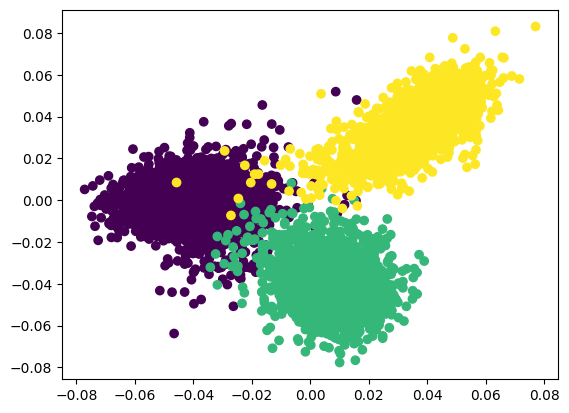

In [32]:
Z=Q.T@Xtrain
print(Z.shape)
plt.scatter(Z[0,:], Z[1,:], c=Ytrain) #c means color -> we color the data based on the label
plt.show()

This graph 
NOTE: LDA is more accurate (in classification), and better shows the distinction between different classes, but is slower compared to PCA.<br> 
PCA is indeed faster, but less accurate than LDA, and classes overlap on each other when plotted, making it diffucult to distinguish them.<br>
We can calculate accuracy using the test sets (average of correct guesses)